In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import leastsq , curve_fit
from scipy.signal import find_peaks
from lmfit.models import ExponentialModel, GaussianModel,LorentzianModel, QuadraticModel

In [ ]:
from heapq import nsmallest
import lumispy

In [ ]:
#pl-data

In [2]:
pl= pd.read_excel(r'C:\Users\Asus\Desktop\solar_cell\Paper 1\pl.xlsx')
pl.dropna(axis=1, how='all',inplace=True)
pl.dropna(axis=0, how='any',inplace=True)
pl=pl.copy().rename(columns={'Unnamed: 0': 'wavelength'})


,wavelength,Sample #1,Sample #2,Sample #3,Sample #4,Sample #5
0,351.0,8.362423,8.322040,5.846693,4.614909,9.212210
1,351.5,8.367572,8.322989,5.878439,4.651046,9.213130
2,352.0,8.357429,8.328711,5.880992,4.667770,9.182086
3,352.5,8.319901,8.334703,5.875514,4.699085,9.158171
4,353.0,8.285076,8.350400,5.862088,4.751971,9.134147
...,...,...,...,...,...,...
533,617.5,6.476886,6.660176,5.873828,2.764193,8.550463
534,618.0,6.431819,6.648390,5.863926,2.756905,8.530504
535,618.5,6.391367,6.639472,5.850224,2.746599,8.523877
536,619.0,6.366954,6.637024,5.828432,2.739335,8.525598


In [ ]:
#excitation wavelenght = 325nm 

In [3]:
#x
x=(((pl.iloc[:,0:1]).to_numpy()).flatten())

#y
#sample1
y1=(((pl.iloc[:,1:2]).to_numpy()).flatten())
#sample2
y2=(((pl.iloc[:,2:3]).to_numpy()).flatten())
#sample3
y3=(((pl.iloc[:,3:4]).to_numpy()).flatten())
#sample4
y4=(((pl.iloc[:,4:5]).to_numpy()).flatten())
#sample5
y5=(((pl.iloc[:,5:6]).to_numpy()).flatten())


# curve fitting

In [4]:
def lorentzian( x, x0, a, gam ):
    return a * gam**2 / ( gam**2 + ( x - x0 )**2 )

def multi_lorentz( x, params ):
    off = params[0]
    paramsRest = params[1:]
    assert not ( len( paramsRest ) % 3 )
    return off + sum( [ lorentzian( x, *paramsRest[ i : i+3 ] ) for i in range( 0, len( paramsRest ), 3 ) ] )

def res_multi_lorentz( params, xData, yData ):
    diff = [ multi_lorentz( x, params ) - y for x, y in zip( xData, yData ) ]
    return diff

In [5]:
def fwhm (y):
    y=y
    pk, properties = find_peaks(y , height=.05, width = 3 ) 
#pk returns peaks position  
# properties returns other properties associated with the peaks

    I = properties ['peak_heights'] #amplitude
    fwhm= (properties['widths']) #full width half maximum 

    res={ 'amplitude':I 
               , 'fwhm':fwhm}

    return res

In [7]:
def fit (x,y):
    y0 =y
    yData =y
    xData =x

    yGround = min( yData ) 
    yData = yData - yGround
    yAmp = max( yData )
    yData = yData / yAmp 

    #initial properties of peaks 
    pk, properties = find_peaks( yData, height = .05, width = 3 )
    #extract peak heights and fwhm 

    I = properties [ 'peak_heights' ]
    fwhm = properties[ 'widths' ]


    guess = [0]

    for i in range( len( pk ) ): 
        guess.append( pk[i] )
        guess.append( I[i] )
        guess.append( fwhm[i] ) 
        
    guess=np.array( guess )


    

    popt, pcov = leastsq( res_multi_lorentz , x0=guess, args=( xData, yData ) )
#x0=Initial guess on independent variables 
# print( popt )


    testData = [ multi_lorentz( x, popt ) for x in xData ]
    fitData = [ yGround + yAmp * multi_lorentz( x, popt ) for x in xData ]
    
    #plot

    fig= plt.figure( figsize=( 20, 10 ) )

    ax= fig.add_subplot( 2, 1, 1 )
    ax.plot( pk, yData[pk], 'o', ms=5 )
    ax.plot( xData, yData, 'ok', ms=1 )
    ax.plot( xData, testData , 'r--', lw=1.5 )

    bx= fig.add_subplot( 2, 1, 2 )

    bx.plot( xData, y0, ls='', marker='o', markersize=2 )
    bx.plot( xData, fitData )


    plt.show()
    
    pk, properties = find_peaks(fitData , height=.05, width = 3 ) 
#pk returns peaks position  
# properties returns other properties associated with the peaks

    I = properties ['peak_heights'] #amplitude
    fwhm= (properties['widths']) #full width half maximum 

    res={ 'amplitude':I 
               , 'fwhm':fwhm}

               
    return  res

lmfit

In [8]:
def lmfitt (x,y,a,s,rough_peak_positions):#a=amplitude s=sigma
    xdat = x
    ydat = y

    def add_peak(prefix, center, amplitude=a, sigma=s):
        peak = LorentzianModel(prefix=prefix)
        pars = peak.make_params()
        pars[prefix + 'center'].set(center)
        pars[prefix + 'amplitude'].set(amplitude)
        pars[prefix + 'sigma'].set(sigma, min=0)
        return peak, pars

   
    model = QuadraticModel(prefix='bkg_')
    params = model.make_params(a=0, b=0, c=0)

    rough_peak_positions = rough_peak_positions

    for i, cen in enumerate(rough_peak_positions):

        peak, pars = add_peak('lz%d_' % (i+1), cen)
        model = model + peak
        params.update(pars)


    init = model.eval(params, x=xdat)
    result = model.fit(ydat, params, x=xdat)
    comps = result.eval_components()


    plt.figure( figsize=( 10, 10 ) )

    plt.plot(xdat, ydat, label='data')
    plt.plot(xdat, result.best_fit, label='best fit')

    for name, comp in comps.items():
        plt.plot(xdat, comp,'--', label=name)
    plt.legend(loc='upper right')
    plt.show()

# print(result.fit_report(min_correl=0.5))
    for parname, param in result.params.items():
            print("%s = %f +/- %f " % (parname, param.value, param.stderr))

    fig= plt.figure( figsize=( 10, 10 ) )

    bx= fig.add_subplot( 2, 1, 2 )
    bx.plot(xdat, ydat, label='data')
    bx.plot(xdat, result.best_fit, label='best fit')
    
    res= {'fwhm and amp of best fit ': fwhm(result.eval())}
    
    return res




#sample1

c:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 3400.
  warnings.warn(errors[info][0], RuntimeWarning)


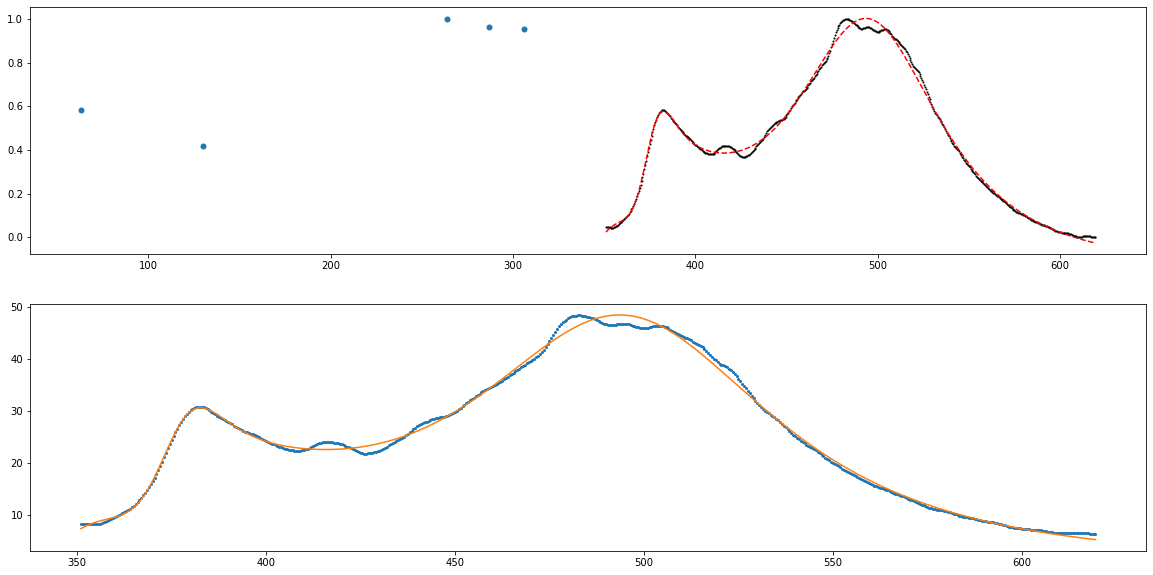

{'amplitude': array([30.58142421, 48.41385883]),
 'fwhm': array([ 32.3956507 , 181.42896471])}

In [9]:
fit(x,y1) 

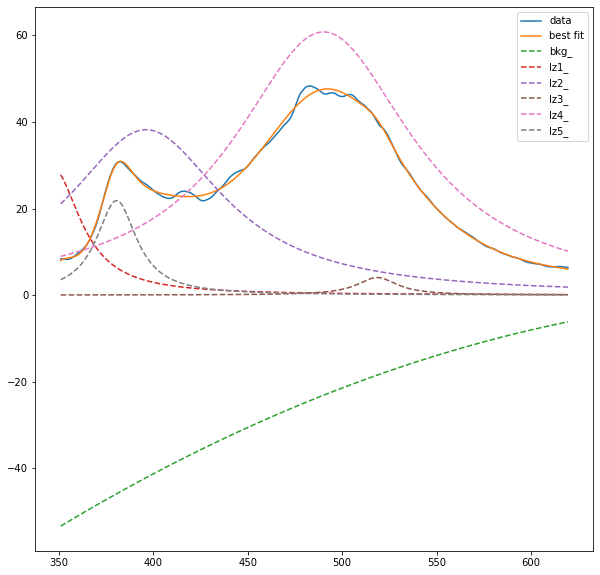

bkg_a = -0.000321 +/- 0.000820 
bkg_b = 0.487698 +/- 1.075788 
bkg_c = -184.993159 +/- 359.290823 
lz1_amplitude = 1632.521041 +/- 3340.467047 
lz1_center = 346.842911 +/- 6.401691 
lz1_sigma = 17.718413 +/- 9.843969 
lz1_fwhm = 35.436827 +/- 19.687937 
lz1_height = 29.328112 +/- 44.036168 
lz2_amplitude = 6017.488132 +/- 10873.143550 
lz2_center = 396.191633 +/- 11.866458 
lz2_sigma = 50.116060 +/- 24.330025 
lz2_fwhm = 100.232120 +/- 48.660051 
lz2_height = 38.219805 +/- 50.563201 
lz3_amplitude = 165.106221 +/- 49.152433 
lz3_center = 518.532911 +/- 0.650986 
lz3_sigma = 12.982044 +/- 2.139541 
lz3_fwhm = 25.964088 +/- 4.279081 
lz3_height = 4.048280 +/- 0.599459 
lz4_amplitude = 11041.491997 +/- 3079.219217 
lz4_center = 490.159187 +/- 1.079443 
lz4_sigma = 57.788798 +/- 4.462072 
lz4_fwhm = 115.577596 +/- 8.924144 
lz4_height = 60.818296 +/- 12.298324 
lz5_amplitude = 893.174985 +/- 229.023010 
lz5_center = 380.568396 +/- 0.281835 
lz5_sigma = 13.026748 +/- 1.194230 
lz5_fwhm = 26

{'fwhm and amp of best fit ': {'amplitude': array([30.90861596, 47.64210319]),
  'fwhm': array([ 29.681691  , 180.71070585])}}

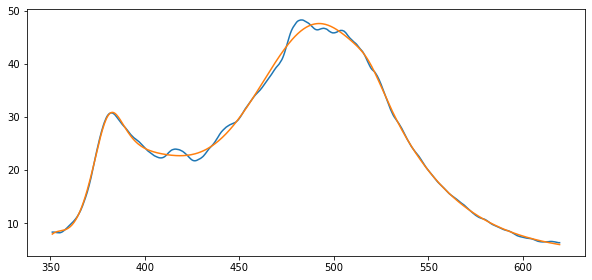

In [10]:
rough_peak_positions1 = (382.5,	416.0,	483.0,	494.5,	504.0)
lmfitt (x,y1,2.45,2.34,rough_peak_positions1)

In [ ]:
# xdat = x
# ydat = y1
# def add_peak(prefix, center, amplitude=2.45, sigma=2.34):
#     peak = LorentzianModel(prefix=prefix)
#     pars = peak.make_params()
#     pars[prefix + 'center'].set(center)
#     pars[prefix + 'amplitude'].set(amplitude)
#     pars[prefix + 'sigma'].set(sigma, min=0)
#     return peak, pars

# model = QuadraticModel(prefix='bkg_')
# params = model.make_params(a=0, b=0, c=0)

# rough_peak_positions = (382.5,	416.0,	483.0,	494.5,	504.0)
# for i, cen in enumerate(rough_peak_positions):
#     peak, pars = add_peak('lz%d_' % (i+1), cen)
#     model = model + peak
#     params.update(pars)

# init = model.eval(params, x=xdat)
# result = model.fit(ydat, params, x=xdat)
# comps = result.eval_components()



# plt.figure( figsize=( 10, 10 ) )

# plt.plot(xdat, ydat, label='data')
# plt.plot(xdat, result.best_fit, label='best fit')
# for name, comp in comps.items():
#     plt.plot(xdat, comp,'--', label=name)
# plt.legend(loc='upper right')
# plt.show()

# # print(result.fit_report(min_correl=0.5))
# for parname, param in result.params.items():
#     print("%s = %f +/- %f " % (parname, param.value, param.stderr))


# sample2

c:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 2200.
  warnings.warn(errors[info][0], RuntimeWarning)


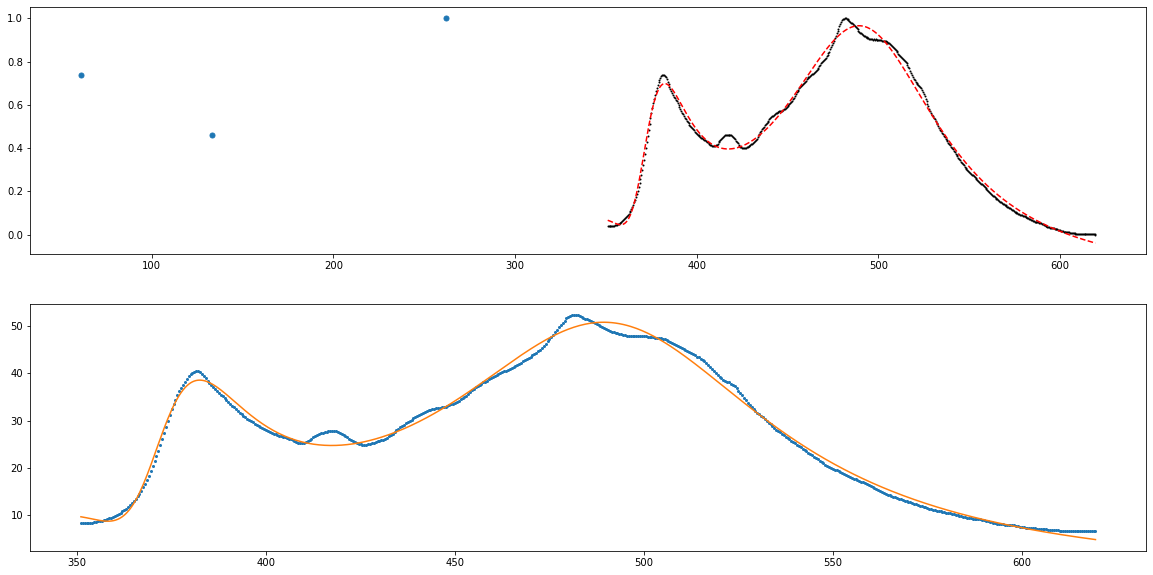

{'amplitude': array([38.5459424 , 50.79176739]),
 'fwhm': array([ 40.99624331, 185.15899833])}

In [11]:
fit(x,y2)

[[Model]]
    (((((Model(parabolic, prefix='bkg_') + Model(lorentzian, prefix='lz1_')) + Model(lorentzian, prefix='lz2_')) + Model(lorentzian, prefix='lz3_')) + Model(lorentzian, prefix='lz4_')) + Model(lorentzian, prefix='lz5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38000
    # data points      = 538
    # variables        = 18
    chi-square         = 321.599738
    reduced chi-square = 0.61846104
    Akaike info crit   = -240.828350
    Bayesian info crit = -163.646896
    R-squared          = 0.99690179
##  Warning: uncertainties could not be estimated:
[[Variables]]
    bkg_a:         -0.00103922 (init = 0)
    bkg_b:          1.10004489 (init = 0)
    bkg_c:         -252.115909 (init = 0)
    lz1_amplitude:  989.870445 (init = 1.5)
    lz1_center:     512.986713 (init = 381.5)
    lz1_sigma:      21.3271316 (init = 1.2)
    lz1_fwhm:       42.6542632 == '2.0000000*lz1_sigma'
    lz1_height:     14.7739306 == '0.3183099*lz1_amplitude/max(1e-

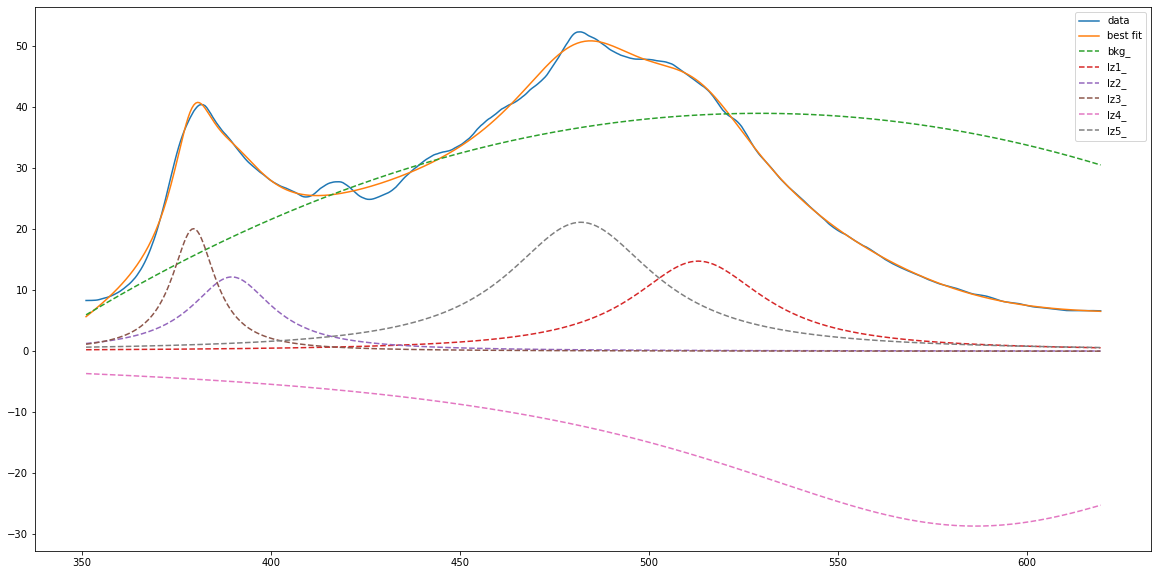

{'fwhm and amp of best fit ': {'amplitude': array([40.7831654 , 50.87091957]), 'fwhm': array([ 31.12325437, 199.76299357])}}


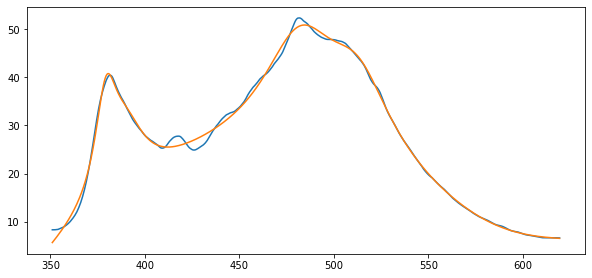

In [14]:
xdat = x
ydat = y2
def add_peak(prefix, center, amplitude=1.5, sigma=1.2):
    peak = LorentzianModel(prefix=prefix)
    pars = peak.make_params()
    pars[prefix + 'center'].set(center)
    pars[prefix + 'amplitude'].set(amplitude)
    pars[prefix + 'sigma'].set(sigma, min=0)
    return peak, pars

model = QuadraticModel(prefix='bkg_')
params = model.make_params(a=0, b=0, c=0)

rough_peak_positions = (381.5	,417.5,482.0,	497.5,	498.5)
for i, cen in enumerate(rough_peak_positions):
    peak, pars = add_peak('lz%d_' % (i+1), cen)
    model = model + peak
    params.update(pars)

init = model.eval(params, x=xdat)
result = model.fit(ydat, params, x=xdat)
comps = result.eval_components()

print(result.fit_report(min_correl=0.5))


plt.figure( figsize=( 20, 10 ) )

plt.plot(xdat, ydat, label='data')
plt.plot(xdat, result.best_fit, label='best fit')
for name, comp in comps.items():
    plt.plot(xdat, comp, '--', label=name)
plt.legend(loc='upper right')
plt.show()


# for parname, param in result.params.items():
#             print("%s = %f +/- %f " % (parname, param.value, param.stderr))

fig= plt.figure( figsize=( 10, 10 ) )

bx= fig.add_subplot( 2, 1, 2 )
bx.plot(xdat, ydat, label='data')
bx.plot(xdat, result.best_fit, label='best fit')
    
res= {'fwhm and amp of best fit ': fwhm(result.eval())}
print(res)

# sampl3

c:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 2200.
  warnings.warn(errors[info][0], RuntimeWarning)


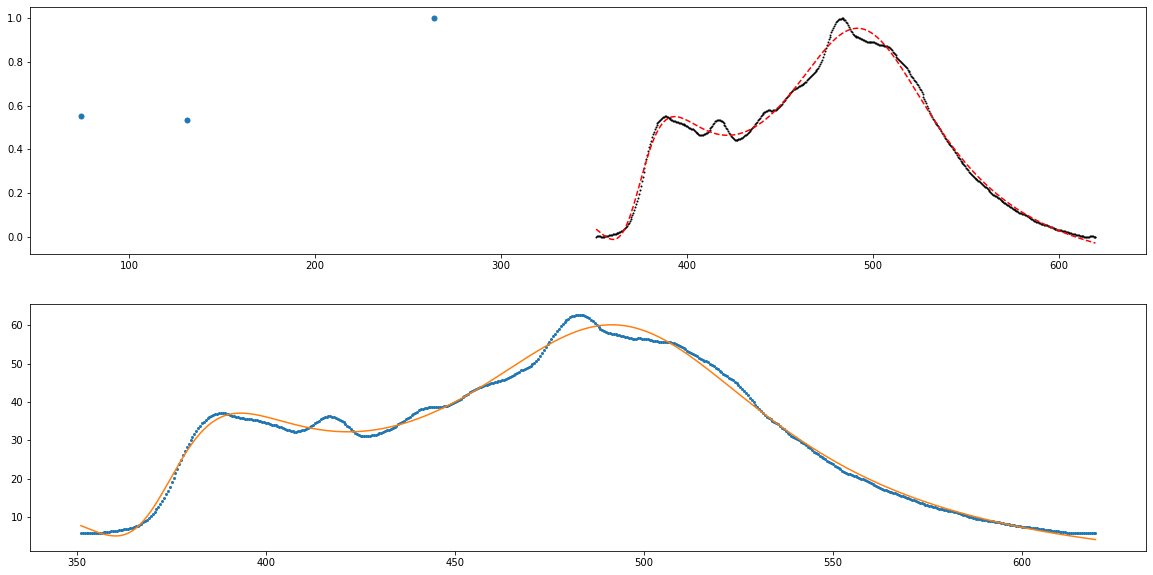

{'amplitude': array([37.10200691, 60.12818322]),
 'fwhm': array([ 39.66372596, 219.90913013])}

In [15]:
fit(x,y3)

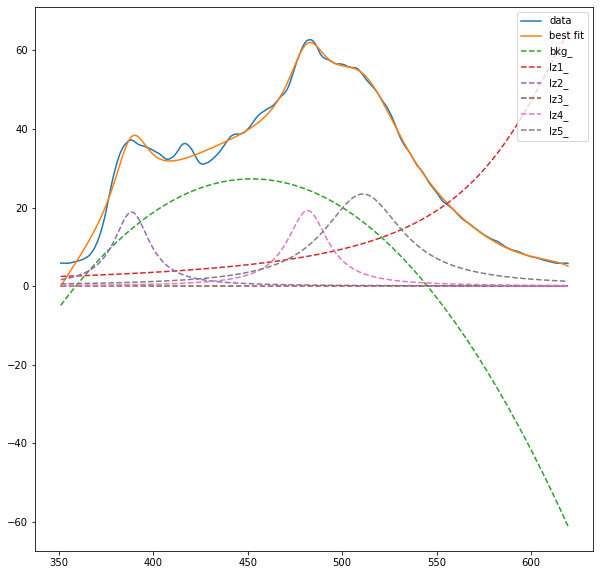

bkg_a = -0.003151 +/- 0.002924 
bkg_b = 2.848895 +/- 0.786509 
bkg_c = -616.642515 +/- 547.636994 
lz1_amplitude = 12697.399997 +/- 24780.935317 
lz1_center = 641.520105 +/- 26.013176 
lz1_sigma = 53.386977 +/- 25.870833 
lz1_fwhm = 106.773953 +/- 51.741665 
lz1_height = 75.705881 +/- 112.135803 
lz2_amplitude = 687.807033 +/- 61.751183 
lz2_center = 388.550233 +/- 0.236299 
lz2_sigma = 11.604108 +/- 0.723879 
lz2_fwhm = 23.208216 +/- 1.447758 
lz2_height = 18.867093 +/- 0.715494 
lz3_amplitude = 216.657588 +/- 78568292.793820 
lz3_center = 1490.681127 +/- 264834341.843930 
lz3_sigma = 17.273650 +/- 8905452.622698 
lz3_fwhm = 34.547300 +/- 17810905.197935 
lz3_height = 3.992454 +/- 2058185.675470 
lz4_amplitude = 799.167408 +/- 101.570969 
lz4_center = 481.658439 +/- 0.437389 
lz4_sigma = 13.218250 +/- 0.979718 
lz4_fwhm = 26.436500 +/- 1.959435 
lz4_height = 19.244824 +/- 1.186886 
lz5_amplitude = 1887.367769 +/- 282.198639 
lz5_center = 511.000879 +/- 0.838817 
lz5_sigma = 25.611522 

{'fwhm and amp of best fit ': {'amplitude': array([38.39845719, 62.00645693]),
  'fwhm': array([ 23.42644137, 226.65642754])}}

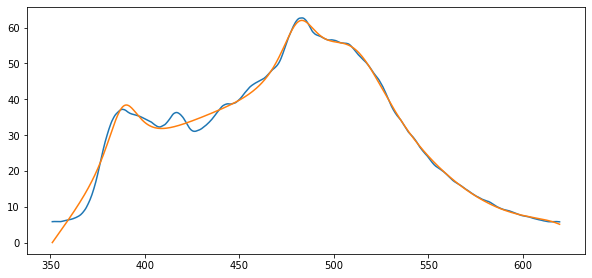

In [16]:
rough_peak_positions3 = (388.0,	416.5,	444.0	,483.0,	499.0)

lmfitt (x,y3,2.45,2.34,rough_peak_positions3)

# sample4

c:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 3400.
  warnings.warn(errors[info][0], RuntimeWarning)


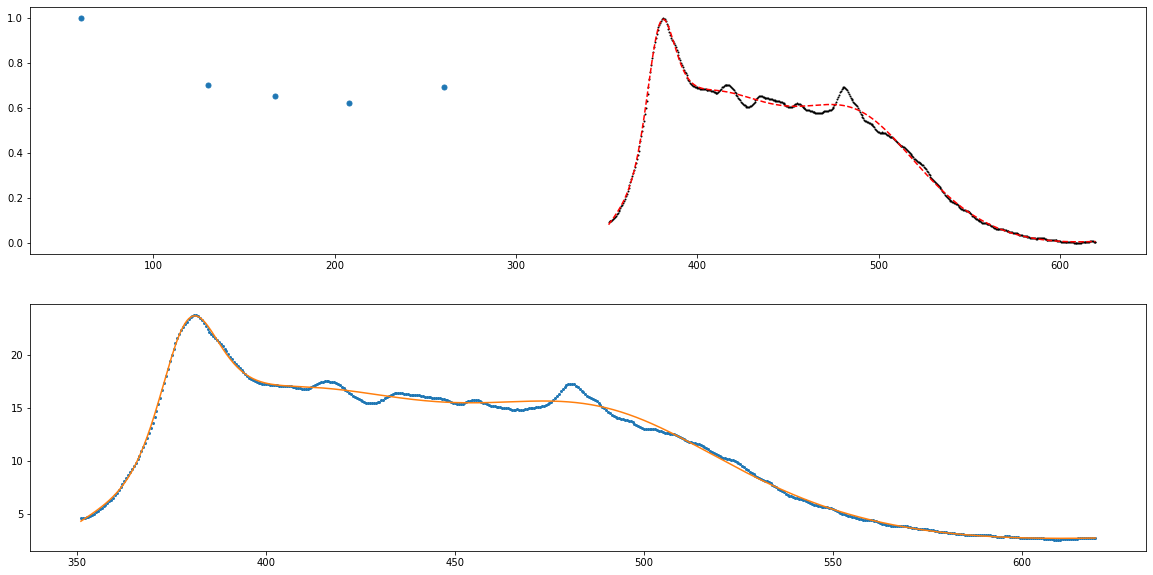

{'amplitude': array([23.6877167 , 15.66305363]),
 'fwhm': array([257.29879698,  31.9303512 ])}

In [17]:
fit(x,y4)

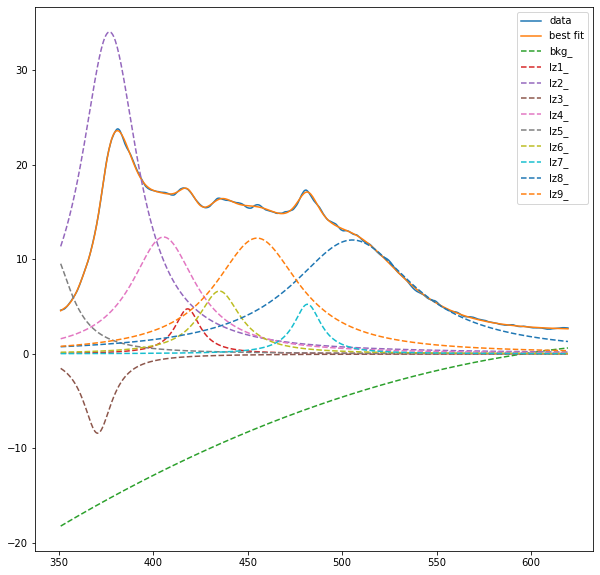

bkg_a = -0.000179 +/- 0.000113 
bkg_b = 0.244030 +/- 0.142610 
bkg_c = -81.776442 +/- 45.233527 
lz1_amplitude = 122.974258 +/- 41.251255 
lz1_center = 418.190533 +/- 0.165006 
lz1_sigma = 8.231010 +/- 0.904445 
lz1_fwhm = 16.462021 +/- 1.808891 
lz1_height = 4.755665 +/- 1.086953 
lz2_amplitude = 1954.215414 +/- 669.042456 
lz2_center = 376.830445 +/- 1.773503 
lz2_sigma = 18.283309 +/- 1.516587 
lz2_fwhm = 36.566619 +/- 3.033174 
lz2_height = 34.022621 +/- 8.934076 
lz3_amplitude = -243.801022 +/- 224.865974 
lz3_center = 370.562722 +/- 0.215924 
lz3_sigma = 9.251923 +/- 1.980943 
lz3_fwhm = 18.503845 +/- 3.961887 
lz3_height = -8.387908 +/- 5.954964 
lz4_amplitude = 813.202376 +/- 272.021743 
lz4_center = 405.423609 +/- 0.814691 
lz4_sigma = 20.968431 +/- 2.650687 
lz4_fwhm = 41.936861 +/- 5.301374 
lz4_height = 12.344766 +/- 2.817527 
lz5_amplitude = 433.847817 +/- 497.856154 
lz5_center = 346.068907 +/- 4.319271 
lz5_sigma = 12.562406 +/- 6.419615 
lz5_fwhm = 25.124812 +/- 12.8392

{'fwhm and amp of best fit ': {'amplitude': array([23.58498275, 17.50974011, 16.41284383, 17.10188452]),
  'fwhm': array([245.01277834,  11.73324329,  23.24691061,  20.39809694])}}

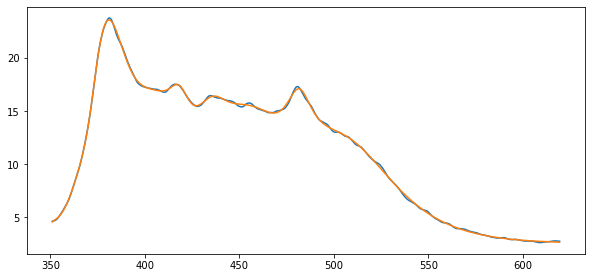

In [19]:
rough_peak_positions4 = (381.0	,402.5	,416.0,	434.5,	455.0	,466.5,	470.0,	481.0,	502.0)

lmfitt (x,y4,4.99506703599645,4.99506703599645,rough_peak_positions4)

In [ ]:
# xdat = x
# ydat = y4
# def add_peak(prefix, center, amplitude=4.99506703599645, sigma=4.99506703599645):
#     peak = LorentzianModel(prefix=prefix)
#     pars = peak.make_params()
#     pars[prefix + 'center'].set(center)
#     pars[prefix + 'amplitude'].set(amplitude)
#     pars[prefix + 'sigma'].set(sigma, min=0)
#     return peak, pars

# model = QuadraticModel(prefix='bkg_')
# params = model.make_params(a=0, b=0, c=0)

# rough_peak_positions = (381.0	,402.5	,416.0,	434.5,	455.0	,466.5,	470.0,	481.0,	502.0)
# for i, cen in enumerate(rough_peak_positions):
#     peak, pars = add_peak('lz%d_' % (i+1), cen)
#     model = model + peak
#     params.update(pars)

# init = model.eval(params, x=xdat)
# result = model.fit(ydat, params, x=xdat)
# comps = result.eval_components()

# print(result.fit_report(min_correl=0.5))


# plt.figure( figsize=( 20, 10 ) )

# plt.plot(xdat, ydat, label='data')
# plt.plot(xdat, result.best_fit, label='best fit')
# for name, comp in comps.items():
#     plt.plot(xdat, comp, '--', label=name)
# plt.legend(loc='upper right')
# plt.show()

# sample5

c:\Users\Asus\anaconda3\lib\site-packages\scipy\optimize\minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 2200.
  warnings.warn(errors[info][0], RuntimeWarning)


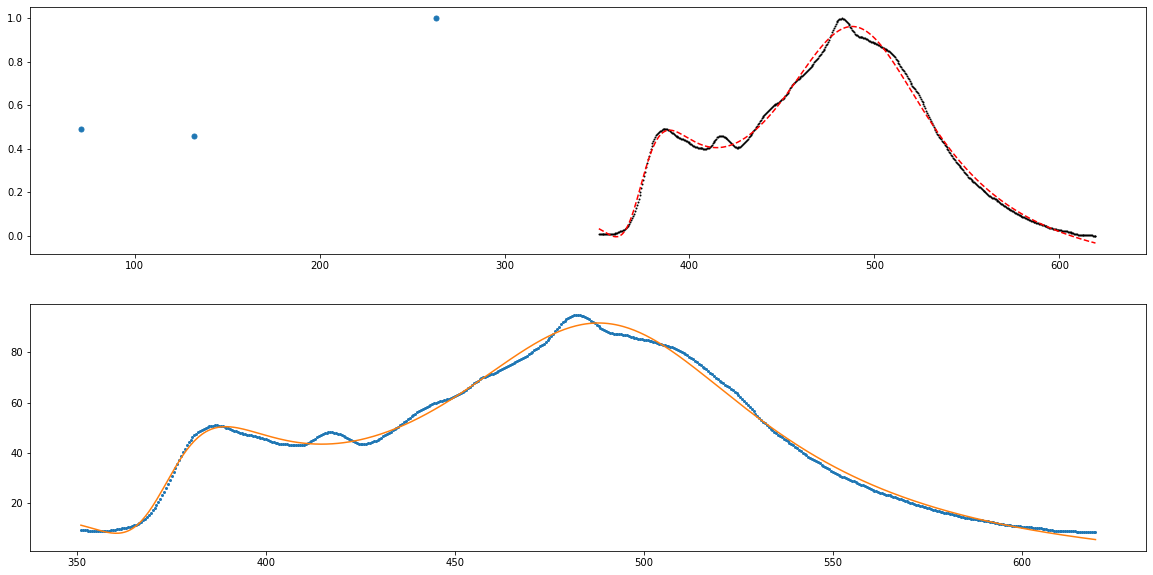

{'amplitude': array([50.40969494, 91.62361629]),
 'fwhm': array([ 34.70015298, 198.72544085])}

In [20]:
fit(x,y5)

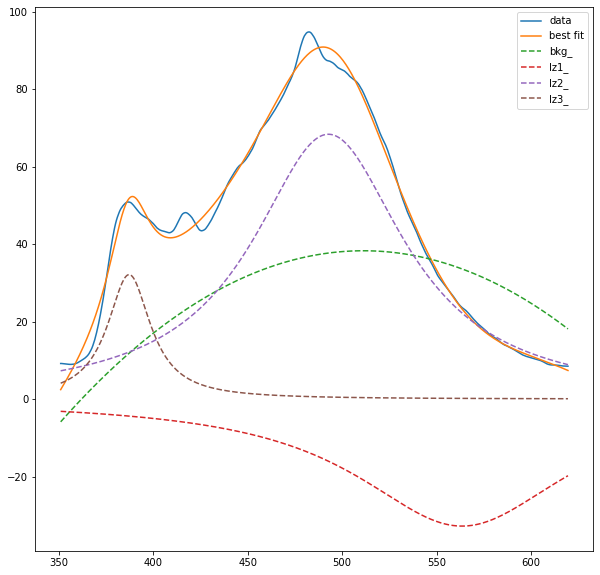

bkg_a = -0.001721 +/- 0.000127 
bkg_b = 1.759336 +/- 0.115723 
bkg_c = -411.372623 +/- 24.993290 
lz1_amplitude = -7115.731348 +/- 2949.705123 
lz1_center = 563.425789 +/- 3.706064 
lz1_sigma = 69.123314 +/- 14.212492 
lz1_fwhm = 138.246627 +/- 28.424983 
lz1_height = -32.767638 +/- 6.908668 
lz2_amplitude = 10547.012844 +/- 1464.499958 
lz2_center = 492.712816 +/- 1.029954 
lz2_sigma = 49.083755 +/- 2.636362 
lz2_fwhm = 98.167510 +/- 5.272723 
lz2_height = 68.397754 +/- 5.942404 
lz3_amplitude = 1402.440126 +/- 85.932145 
lz3_center = 387.212841 +/- 0.241775 
lz3_sigma = 13.880352 +/- 0.634690 
lz3_fwhm = 27.760704 +/- 1.269380 
lz3_height = 32.161329 +/- 0.798876 


{'fwhm and amp of best fit ': {'amplitude': array([52.32768033, 90.9173243 ]),
  'fwhm': array([ 27.17110526, 209.21074685])}}

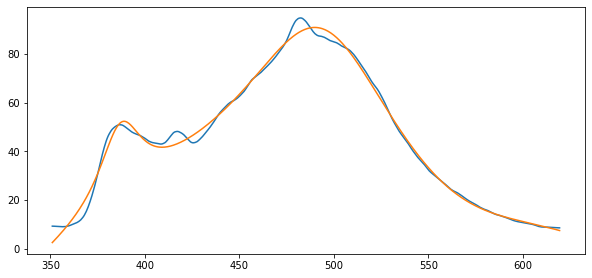

In [21]:
rough_peak_positions5 = (386.5,	417.0	,482.5)
lmfitt (x,y5,3.4,3.,rough_peak_positions5)

In [ ]:
# xdat = x
# ydat = y5
# def add_peak(prefix, center, amplitude=3.4, sigma=3.):
#     peak = LorentzianModel(prefix=prefix)
#     pars = peak.make_params()
#     pars[prefix + 'center'].set(center)
#     pars[prefix + 'amplitude'].set(amplitude)
#     pars[prefix + 'sigma'].set(sigma, min=0)
#     return peak, pars

# model = QuadraticModel(prefix='bkg_')
# params = model.make_params(a=0, b=0, c=0)

# rough_peak_positions = (386.5,	417.0	,482.5)
# for i, cen in enumerate(rough_peak_positions):
#     peak, pars = add_peak('lz%d_' % (i+1), cen)
#     model = model + peak
#     params.update(pars)

# init = model.eval(params, x=xdat)
# result = model.fit(ydat, params, x=xdat)
# comps = result.eval_components()

# print(result.fit_report(min_correl=0.5))


# plt.figure( figsize=( 10, 10 ) )

# plt.plot(xdat, ydat, label='data')
# plt.plot(xdat, result.best_fit, label='best fit')
# for name, comp in comps.items():
#     plt.plot(xdat, comp, '--', label=name)
# plt.legend(loc='upper right')
# plt.show()

In [ ]:
# y=list((((pd.DataFrame(result.best_fit)).to_numpy()).flatten()))
# X=list((((pd.DataFrame(x)).to_numpy()).flatten()))
# np.array(x,y)

In [57]:
#electrical properties of ZnO nanostructure_assited Si solar cell _ Fwhm amd amp Pldata _ XRDpy 

x1={'ff':[40,38,44,39,41],'Eff':[9.1,8.6,10.6,9,10.4],
'fwhmI_pl ':[29.681691  , 31.12325437 , 23.42644137 , 245, 27.17110526], 'ampI_pl':[ 30.90861596  , 40.7831654   , 38.39845719   , 23.58498275   , 52.32768033   ],
'fwhmII_pl ':[180.71070585  ,  199.76299357 , 226.65642754 , 20.39809694, 209.21074685] , 'ampII_pl':[ 47.64210319 , 50.87091957, 62.00645693, 17.10188452 , 90.9173243   ],
 'FWHM_xrd (degrees) ':[0.51,0.33,0.18,0.51,0.19]  ,'max 2-theta_xrd' :[36.86 ,36.79,32.12,35.69,32.12 ]
   }  

x1 = pd.DataFrame(x1,index=['sample1','sample2','sample3','sample4','sample5'])
x1

,ff,Eff,fwhmI_pl,ampI_pl,fwhmII_pl,ampII_pl,FWHM_xrd (degrees),max 2-theta_xrd
sample1,40,9.1,29.681691,30.908616,180.710706,47.642103,0.51,36.86
sample2,38,8.6,31.123254,40.783165,199.762994,50.870920,0.33,36.79
sample3,44,10.6,23.426441,38.398457,226.656428,62.006457,0.18,32.12
sample4,39,9.0,245.000000,23.584983,20.398097,17.101885,0.51,35.69
sample5,41,10.4,27.171105,52.327680,209.210747,90.917324,0.19,32.12


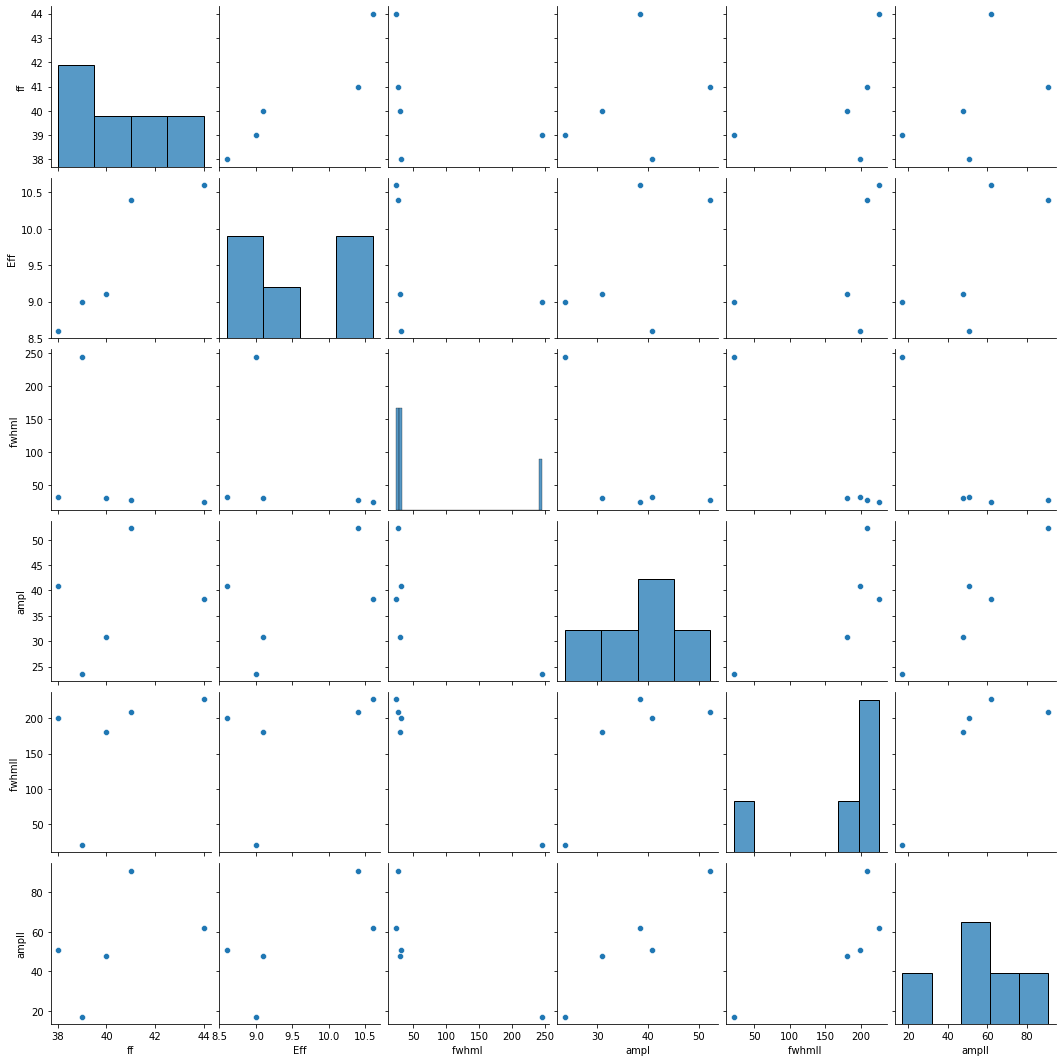

In [55]:
sns.pairplot(x1)

# Uv

In [ ]:
uv= pd.read_excel(r'C:\Users\Asus\Desktop\solar_cell\Paper 1\absorption.xlsx' ,sheet_name='Sheet2')
uv.dropna(axis=1, how='all',inplace=True)
uv=uv.copy().rename(columns={'Unnamed: 0': 'wavelength(nm)',
                           })
uv.drop(['Unnamed: 3','Unnamed: 6','Unnamed: 9','Unnamed: 12'], axis=1, inplace=True)